In [1]:
from commonfunctions import *
from scipy.signal import find_peaks, find_peaks_cwt
import math

# Show the matlpotlib figures inside the notebook
%matplotlib inline

In [19]:
def binraization(img,n=8,t=15):

    outputimg = np.zeros(img.shape)
    intimg = np.zeros(img.shape)
    h = img.shape[1]
    w = img.shape[0]
    s= min(w,h)//n
    count = s**2
    img = np.pad(img,s,"constant")
    intimg = np.cumsum(img ,axis =1)
    intimg = np.cumsum(intimg ,axis =0)
    a = np.roll(intimg,-s//2,axis =0)
    a = np.roll(a,-s//2,axis =1)
    a[:,-s//2:]=a[-s//2-1,-s//2-1]
    a[-s//2:,:]=a[-s//2-1,-s//2-1]
    b = np.roll(intimg,s//2+1,axis =0)
    b = np.roll(b,-s//2,axis =1)
    b[0:s//2+1,:]=0
    b[:,-s//2:]=0
    
    c = np.roll(intimg,s//2+1,axis =1)
    c = np.roll(c,-s//2,axis =0)
    c[:,0:s//2+1]=0
    c[-s//2:,:]=0
    
    d = np.roll(intimg,s//2+1,axis =0)
    d = np.roll(d,s//2+1,axis =1)
    d[0:s//2+1,:]=0
    d[:,0:s//2+1]=0

    sum = (a-b-c+d)*(100-t)/100
    outputimg = np.where(img>sum/count, 1, 0)
    return outputimg[s:-s,s:-s]

def segement_hand_written(img):
    h , w = img.shape 
    window , width = get_dimensions(w,h)
    fimg = median(img)
    glares = (fimg > 195)
    bimg = binraization(fimg,window,7)
    output = (bimg ) - (glares)
    output = median(output)
    output = binary_dilation(1-output)
    vse = np.array([[0,1,0],
                    [0,1,0],
                    [0,1,0]      ])

    hse = np.array([[0,0,0],
                    [1,1,1],
                    [0,0,0]
    ])
    output = binary_dilation(output , vse)
    output = binary_dilation(output , hse)
    output = 1 - output
    return output #the reuslt is binary image
def getLines(img, thickness, distance):
    rows_sum = np.sum(1 - img, axis=1)
    m = np.max(rows_sum)
    w = 500
    result = np.ones((rows_sum.shape[0],500), dtype="uint8")
    result = result * 255
    # for row in range(img.shape[0]):
    #     if rows_sum[row] != 0:
    #         cv2.line(result, (0,row), (int(rows_sum[row]*w/m),row), (0,0,0), 1)
    # cv2.imshow("a", cv2.resize(result, (960, 540)))
    print(np.sort(rows_sum)[rows_sum.shape[0] // 2])
    print(img.shape[1] * 0.5)
    lines,_  = find_peaks(rows_sum, height = 0, distance=distance+thickness//2)
    return lines

def segmentImage(lines, distance, height):
    detected_lines = np.zeros((height,))
    detected_lines[lines] = 1

    starts = np.array((detected_lines[:-1] == 1) & (detected_lines[1:] == 0))
    starts_ix = np.where(starts)[0] + 1
    ends = np.array((detected_lines[:-1] == 0) & (detected_lines[1:] == 1))
    ends_ix = np.where(ends)[0]

    starts_ix = starts_ix[:-1]
    ends_ix = ends_ix[1:]

    halfs = [0]

    for i in range(len(starts_ix)):
        diff = ends_ix[i] - starts_ix[i]
        if diff > 5 * distance:
            halfs.append((ends_ix[i] + starts_ix[i])//2)

    halfs.append(height-1)

    return halfs

../inputs/test-set-scanned/test-cases
2 20
20760
752.5
[ 21  45  69  90 112 134 157]
[0, 1504]


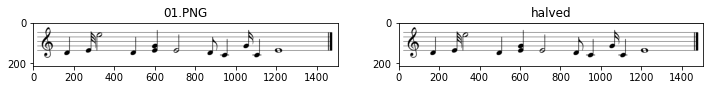

2 17
24473
791.5
[ 19  42  61  97 117 145 178 201 219 238 256 275 295 323 346 364 384 404
 423 441 460 483]
[0, 1582]


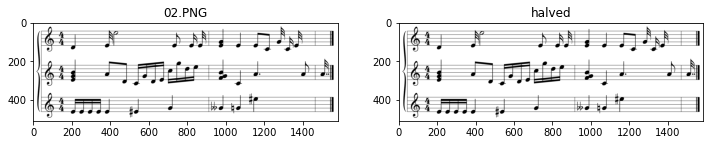

3 29
18603
669.5
[ 22  58  88 122 183 231]
[0, 1338]


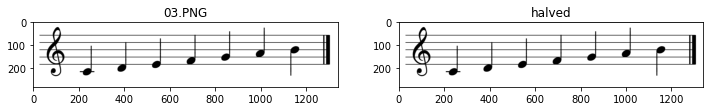

2 18
21547
772.0
[ 20  41  61  81 101 120 142 171]
[0, 1543]


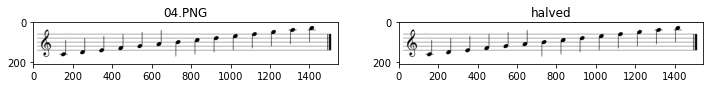

3 34
17812
620.0
[ 23  64 103 140 177 214 256]
[0, 1239]


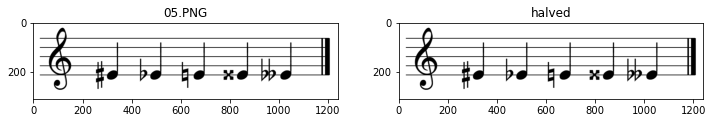

4 39
15048
564.5
[ 21  67 111 154 200 244 287]
[0, 1128]


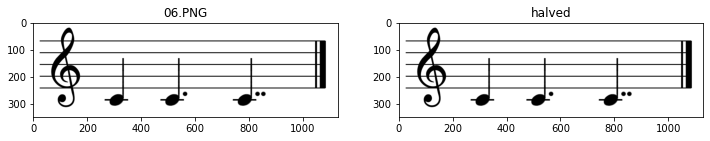

5 50
12897
454.5
[ 24  78 136 191 245 300 354]
[0, 908]


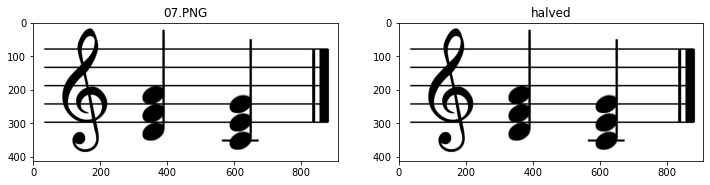

4 45
14805
502.0
[ 21  94 143 192 286 335]
[0, 1003]


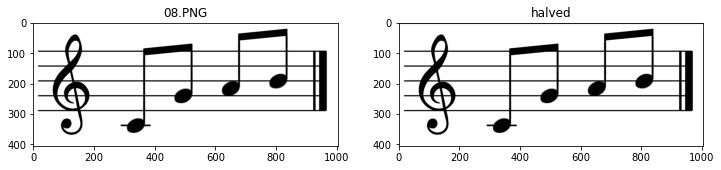

3 39
18680
588.5
[ 35  78 160 205 248 290]
[0, 1176]


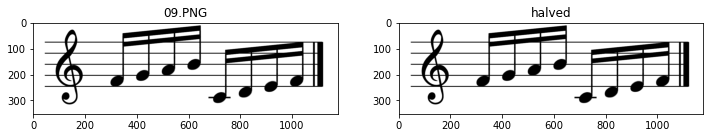

5 52
12080
436.5
[ 10  71 129 187 244 302 389]
[0, 872]


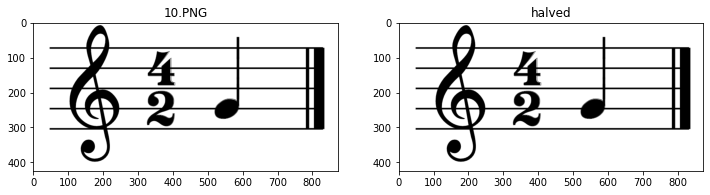

2 17
5939
217.0
[ 36  58  77  95 114 133 156]
[0, 433]


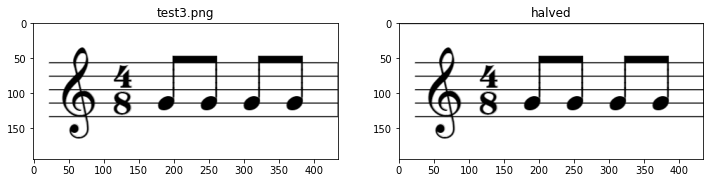

3 27
8603
217.0
[ 80 114 143 178 213]
[0, 433]


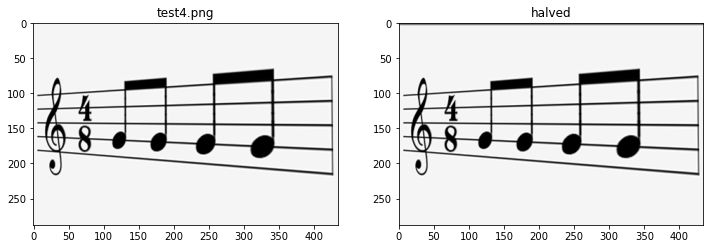

2 18
8277
217.0
[ 74  95 129 148 177 203 237]
[0, 433]


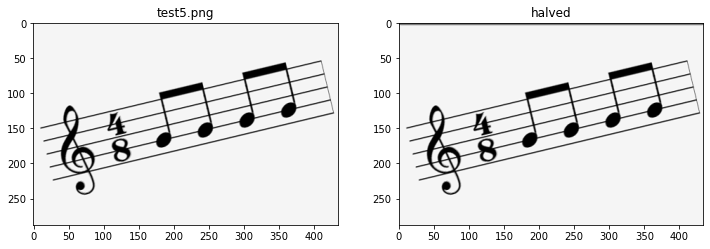

3 27
10226
217.0
[  7  44  72 113 166 217 272]
[0, 433]


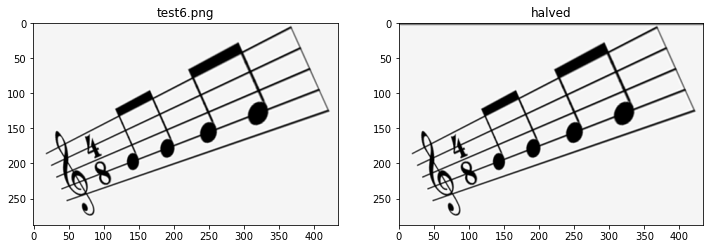

1 21
10187
469.0
[ 37  59  81 123 145 167 208 230 252 280 305 326 348 370]
[0, 937]


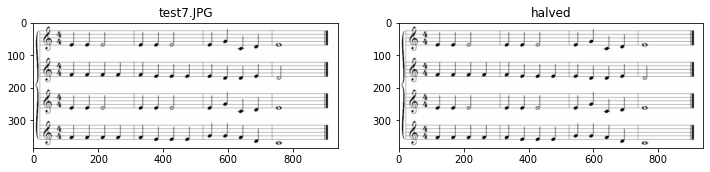

1 16
7204
203.5
[ 14  31  48  66  83 101 119]
[0, 406]


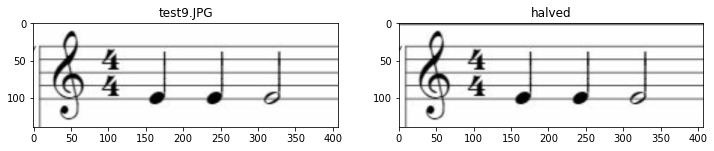

In [20]:
images, files = load_images_from_folder("../inputs/test-set-scanned/test-cases")
# images, files = load_images_from_folder("../inputs/test-set-camera-captured/test-cases")
outpath = "../outputs/"
for image, file in zip(images, files):
    h, w = image.shape
    window , width = get_dimensions(w,h)
    hist = histogram(image,nbins=256,source_range='dtype')
    hist_acc = np.cumsum(hist[0])
    tratio = ((hist_acc[255]-hist_acc[206] + hist_acc[49]-hist_acc[0]) / hist_acc[-1])*100
    segmented = []
    if tratio < 4:
        segmented = segement_hand_written(image)
    elif 75 > tratio > 4:
        segmented = binraization(image,window,35)
    else: 
        segmented = (image > 150).astype("uint8")

    thickness, distance = get_lengthes(segmented)
    print(thickness, distance)
    lines = getLines(image, thickness, distance)
    print(lines)
    halfs = segmentImage(lines, distance, image.shape[1])
    print(halfs)
    im = image.copy()
    for half in halfs:
        cv2.line(im, (0, half), (im.shape[1], half), (125,125,125), 3, cv2.LINE_AA)
    show_images([image, im], [file, "halved"])
    cv2.imwrite(outpath + file, im)